# COMP5328 - Advanced Machine Learning

## Tutorial - Domain Adaptation and Transfer Learning

**Semester 2, 2025**

**Objectives:**

* To understand the concept of transfer learning.
* To understand how to correct covariate shift by kernel mean matching.

**Instructions:**

* Exercises to be completed on IPython notebook such as: 
   * Ipython 3 (Jupyter) notebook installed on your computer http://jupyter.org/install (you need to have Python installed first https://docs.python.org/3/using/index.html )
   * Web-based Ipython notebooks such as Google Colaboratory https://colab.research.google.com/ 
   
* If you are using Jupyter intalled on your computer, Go to File->Open. Drag and drop "week9_tutorial.ipynb" file to the home interface and click upload. 
* If you are using Google Colaboratory, Click File->Upload notebook, and and upload "week9_tutorial.ipynb" file
* Complete exercises in "week9_tutorial.ipynb".
* To run the cell you can press Ctrl-Enter or hit the Play button at the top.
* Scikit-learn library is installed within Anaconda.
* Complete all exercises marked with **TODO**.
* Save your file when you are done with the exercises, so you can show your tutor next week.

Lecturers: Tongliang Liu

## 1. A Brief Introduction of Transfer Learning

* In many machine learning algorithms, it is often assumed that training data and test data have the same distribution. However, this assumption may not be true in many applications. For example, the health records of patients vary from different age groups or different hospitals. Sometimes, we may have a classification or regression task in one domain of interest (say, health records of children), but we only have sufficient training data in another domain of interest (say, health records of adults). In this situation, transfering useful knowledge between different domains is very important.


* Transfer learning is a technique to learn transferable knowledge between different domains in which the data distributions are different. It can be applied to problems like classification, regression and clustering, and also has a wide range of applications in fields such as medical analysis and computer vision.


* Various methods have been proposed in transfer learning. For more information, please read the following reference: Pan, Sinno Jialin, and Qiang Yang. "A survey on transfer learning." IEEE Transactions on knowledge and data engineering 22.10 (2010): 1345-1359.


* In this tutorial, we mainly consider the kernel mean matching method for covariate shift problem.

## 2. Covariate Shift

### 2.1 Problem Setup

* Let $X\in \mathcal{X}$ and $Y\in \mathcal{Y}$ be the variables of features and labels, respectively. Here, $\mathcal{X}$ and $\mathcal{Y}$ are the feature space and label space, respectively. We assume that $X$ and $Y$ are jointly distributed according to the distribution $p(X,Y)$.


* We use superscript $S$ (resp. $T$) or subscript $s$ (resp. $t$) to represent source domain (resp. target domain). In transfer learning, the distributions $p_s(X,Y)$ and $p_t(X,Y)$ can change in various ways across different domains. In this tutorial, we study a very simple scenario: covariate shift. In covarite shift, we assume that only $p(X)$ change but $p(Y|X)$ remains unchanged across domain. Mathematically, $p_s(X,Y)=p(Y|X)p_s(X)$ and $p_t(X,Y)=p(Y|X)p_t(X)$.


* We denote $\{(x_1^S,y_1^S),\cdots,(x_n^S,y_n^S)\}$ as the sample independently and identically drawn from $p_s(X,Y)$ and $\{(x_1^T,y_1^T),\cdots,(x_m^T,y_m^T)\}$ as the sample independently and identically drawn from $p_t(X,Y)$. Here, $n$ and $m$ represent the sample sizes.


* Given the labeled training sample $\{(x_1^S,y_1^S),\cdots,(x_n^S,y_n^S)\}$ from source domain and unlabeled test data $\{x_1^T,\cdots,x_m^T\}$ from target domain, our goal is to learn a good hypothesis function $f$ such that $f(x^T)$ can predict $y^T$ of $x^T$.

### 2.2 Toy Regression Example

* More details about this example can be found at 

  Huang, Jiayuan, et al. "Correcting sample selection bias by unlabeled data." Advances in Neural Information Processing Systems. 2007.
  
  
* In this example, we study regression problem. The features used for training in source and target domain have distributions $p_s(X) \sim \mathcal{N}(0.5,0.5^2)$ and $p_t(X) \sim \mathcal{N}(0, 0.3^2)$, respectively. The labels are generated according to $y = -x + x^3 + \epsilon$, where $\epsilon$ is Gaussian noise with standard deviation $0.3$.

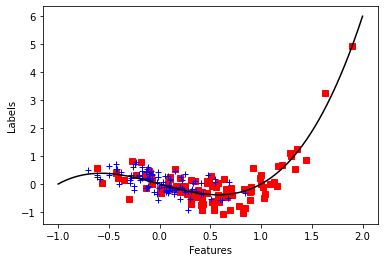

In [1]:
import numpy as np
import numpy.linalg as lng
import matplotlib.pyplot as plt

# Features and labels in source domain
Xtr = np.random.normal(0.5, 0.5, (100,1))
Ytr = -Xtr + Xtr**3 + np.random.normal(0.0, 0.3, (100,1))

# Features and labels in target domain
Xts = np.random.normal(0.0, 0.3, (100,1))
Yts = -Xts + Xts**3 + np.random.normal(0.0, 0.3, (100,1))

# Data used for plot curve y = -x + x^3
Xtmp = np.linspace(-1,2,2000)
Ytmp = -Xtmp + Xtmp**3

plt.plot(Xtr,Ytr,'rs',Xts,Yts,'b+',Xtmp,Ytmp,'k')
plt.xlabel('Features')
plt.ylabel('Labels')
plt.show()

### 2.3 Ordinary Least Square
* To solve this problem, we first use linear regression model.  As in tutorial 1&2, ordinary least square is used to estimate parameters in linear regression model. More details about ordinary least square can also be found at https://en.wikipedia.org/wiki/Ordinary_least_squares.

The error of the model trained on source data is: 0.2461.
The error of the model trained on target data is: 0.0786.


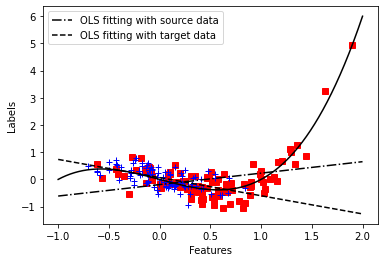

In [2]:
# Least square 
def OLS(X,Y):
    """Estimate parameters of linear regression model using ordinary least square.
    Input: 
       X: array, shape = [n,d]
          The features.
       Y: array, shape = [n]
          The labels.
       gamma: array, shape = [n]
          The weights for training examples.
    Output:
       beta: array, shape = [d+1]
          The parameters of linear regression model.
    """
    n = len(Y)
    X = np.hstack((X, np.ones((n,1))))
    
    X_t = np.transpose(X)
    b = np.dot(X_t,Y)
    covInv = lng.inv(np.dot(X_t,X))
    beta = np.dot(covInv, b)
    return beta

# Estimate parameters of the linear regression model using training (source) data and test (target) data
# Note that, in the setting of covariate shift, the labels for test data are supposed to be unknown. 
# We use them only for illustration.
betaTr = OLS(Xtr,Ytr) # training data
betaTs = OLS(Xts,Yts) # test data

# the average errors on test data
errorTr = np.sum((Xts*betaTr[0] + betaTr[1] - Yts)**2)/len(Yts)
errorTs = np.sum((Xts*betaTs[0] + betaTs[1] - Yts)**2)/len(Yts)
print("The error of the model trained on source data is: %.4f."%(errorTr))
print("The error of the model trained on target data is: %.4f."%(errorTs))

# Plot the estimated lines
pred_Ytr = Xtmp*betaTr[0] + betaTr[1]
pred_Yts = Xtmp*betaTs[0] + betaTs[1]

# We aim to (1) see the differences between the lines estimated using data in source and target domain;
# (2) see the difference between the observed labels and these estimated lines
plt.plot(Xtr,Ytr,'rs',Xts,Yts,'b+',Xtmp,Ytmp,'k')
plt.plot(Xtmp,pred_Ytr,'k-.',label='OLS fitting with source data')
plt.plot(Xtmp,pred_Yts,'k--',label='OLS fitting with target data')
plt.legend(loc='upper left', shadow=False)
plt.xlabel('Features')
plt.ylabel('Labels')
plt.show()

### 2.4 Sample Reweighting
* According to the results in Section 2.3, we can see, if we directly use source data to train a model, this model cannot generalize well on target data when covariate shift exists. Thus, we need to correct this shift. Here, we introduce a sample reweighting strategy.


* Recall the definition of expected risk and empirical risk given a loss function $\ell$ that measures the performance of a hypothesis function $f$. They are 
\begin{equation}
R(f) = \mathbb{E}_{(X,Y)\sim p(X,Y)} \left[\ell(f(X),Y)\right],
\end{equation}

    and 
\begin{equation}
R_n(f) = \frac{1}{n} \sum_{i=1}^n \ell(f(x_i),y_i).
\end{equation}
    
    
* Then, in order to find a good hypothesis function $f$ to predict $y^T$ of $x^T$, we need to minimize the expected risk with respect to distribution $p_t(X,Y)$; that is
\begin{equation}
R(f) = \mathbb{E}_{(X,Y)\sim p_t(X,Y)} \left[\ell(f(X),Y)\right].
\end{equation}


* However, in unsupervised transfer learning, we are only given labeled training sample from $p_s(X,Y)$ and unlabeled features from $p_t(X)$. We can use a sample reweighting strategy as follows:
\begin{equation}
R(f) = \mathbb{E}_{(X,Y)\sim p_t(X,Y)} \left[\ell(f(X),Y)\right] = \mathbb{E}_{(X,Y)\sim p_s(X,Y)} \left[\frac{p_t(X,Y)}{p_s(X,Y)} \ell(f(X),Y)\right] = \mathbb{E}_{(X,Y)\sim p_s(X,Y)} \left[\gamma(X,Y)\ell(f(X),Y)\right],    \quad (1)
\end{equation}
    where $\gamma(X,Y)$ is the weight on each example. Note that, here, we assume the support set of $p_t(X,Y)$ is contained in the support of $p_s(X,Y)$. Otherwise, reweighting strategy cannot be used (think about why).
    

* After we have $\gamma(X,Y)$, we can minimize following empirical risk to find a good hypothesis function:
\begin{equation}
R_n(f) = \frac{1}{n} \sum_{i=1}^n \gamma(x^S_i,y^S_i) \ell(f(x^S_i),y^S_i).
\end{equation}


* Specifically, in covariate shift, due to the assumption that $p_t(Y|X)=p_s(Y|X)=p(Y|X)$ is the same, then we have 
\begin{equation}
\gamma(X,Y) = \frac{p_t(X,Y)}{p_s(X,Y)} = \frac{p_t(Y|X)p_t(X)}{p_s(Y|X)p_s(X)} = \frac{p_t(X)}{p_s(X)} = \gamma(X).
\end{equation}
    
**Exercise 2.4.1**
* Try to understand Eq. (1) by using the definition of expected risk.


* Assume that $\gamma(X)$ is known for each feature. Try to implement the weighted version for the ordinary least square.
  
    Hint: the objective function for weighted least square is 
\begin{equation}
\textrm{minimize} \quad \frac{1}{n} \sum_{i=1}^n \gamma(x^S_i) (\beta^{\top} x^S_i-y^S_i)^2,
\end{equation}
    where $\beta$ are the parameters.
    
    You can minimize this objective function by gradient descent method or you can derive an explict form of the solution: $\beta = (\mathbf{x}^{\top}\Gamma \mathbf{x})^{-1} \mathbf{x}^{\top} \Gamma \mathbf{y}$. Here, same with those in tutorial 1 & 2, $\mathbf{x}$ is the data design matrix: $\begin{bmatrix}
    x_1       & x_2 & x_3 & \dots & x_n \\
    1       & 1 & 1 & \dots & 1
\end{bmatrix}^{\top}$, $\mathbf{y} = [y_1,\cdots,y_n]^{\top}$, and $\Gamma$ is the diagonal matrix with diagonal $(\gamma_1,\cdots,\gamma_n)$.

In [3]:
def weightedLS(X,Y,gamma):
    """Estimate parameters of linear regression model using weighted least square.
    Input: 
       X: array, shape = [n,d]
          The features.
       Y: array, shape = [n]
          The labels.
       gamma: array, shape = [n]
          The weights for training examples.
    Output:
       beta: array, shape = [d+1]
          The parameters of linear regression model.
    """
    #TODO

    return beta

# generate random weights
gamma = np.random.rand(100)
gamma = gamma/sum(gamma) # normalized to 1
betaRnd = weightedLS(Xtr,Ytr,gamma)

# Plot the estimated lines
pred_Yrnd = Xtmp*betaRnd[0] + betaRnd[1]

# estimation error on test data
errorRnd = np.sum((Xts*betaRnd[0] + betaRnd[1] - Yts)**2)/len(Yts)
print("The error of the model trained on source data (OLS) is: %.4f."%(errorTr))
print("The error of the model trained on target data (OLS) is: %.4f."%(errorTs))
print("The error of the model trained on source data (WeightedLS+Rnd) is: %.4f."%(errorRnd))

# Show the result of random weights
plt.plot(Xtr,Ytr,'rs',Xts,Yts,'b+',Xtmp,Ytmp,'k')
plt.plot(Xtmp,pred_Ytr,'k-.',label='OLS fitting with source data')
plt.plot(Xtmp,pred_Yts,'k--',label='OLS fitting with target data')
plt.plot(Xtmp,pred_Yrnd,'k:',label='WeightedLS fitting with source data (random)')
plt.legend(loc='upper left', shadow=False)
plt.xlabel('Features')
plt.ylabel('Labels')
plt.show()

NameError: name 'beta' is not defined

#### 2.4.1 Kernel Mean Matching for Estimating $\gamma(X)$
* The only problem remained is to estimate $\gamma(X,Y)$. 


* In covariate shift, $\gamma(X,Y)=\gamma(X)=p_t(X)/p_s(X)$. We can first estimate these distributions by density estimation methods. But in this tutorial, we choose the kernel mean matching methods. 


**Kernel Mean Embedding**
* Let $\phi: \mathcal{X}\to \mathcal{H}$ be a feature map into a reproducing kernel Hilbert space (RKHS) $\mathcal{H}$; and $k: \mathcal{X}\times \mathcal{X} \to \mathbb{R}$ be the kernel function associated with this RKHS, where $k(x_1,x_2)=\langle \phi(x_1), \phi(x_2)\rangle_{\mathcal{H}}, \forall x_1,x_2 \in \mathcal{X}$.


* Now, denote $\mu:\mathcal{P}\to \mathcal{H}$ as an expectation operater:
\begin{equation}
\mu(p) = \mathbb{E}_{X \sim p(X)} \left[\phi(X)\right],
\end{equation}
    
    where $\mathcal{P}$ is the space of all possible distributions and $\mu$ is known as the kernel mean embedding of distribution $p$. Similar to the relationship between expected risk and empirical risk, we can approximate the kernel mean by its empirical counterpart:
\begin{equation}
\hat{\mu}(p) = \frac{1}{n} \sum_{i=1}^n \phi(x_i).
\end{equation}
    

* Given a special kind of kernel functions, the expectation operator $\mu$ is a one-to-one mapping from $\mathcal{P}$ to $\mathcal{H}$. For more information about RKHS and kernel mean embedding, please refer to 

    (1) https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space;
    
    (2) Muandet, Krikamol, et al. "Kernel mean embedding of distributions: A review and beyond." Foundations and Trends® in Machine Learning 10.1-2 (2017): 1-141.
    

* Note that, in most conditions, we actually cannot have the explict form of $\phi$ but know the kernel function $k$. Therefore, in the following problem, we will finally use the kernel matrix instead of feature map $\phi$.
    
    
**Kernel Mean Matching**
* Now, given a kernel function, then the distributions can be represented by the kernel means. According to $\gamma(X)=\frac{p_t(X)}{p_s(X)}$ (i.e., $p_t(X) = \gamma(X)p_s(X)$), we have 
\begin{equation}
\mu(p_t(X)) = \mathbb{E}_{X\sim p_t(X)} \left[\phi(X)\right] = \mathbb{E}_{X\sim p_s(X)} \left[\gamma(X) \phi(X)\right].
\end{equation}


* It can be proved that when the square error $\|\mu(p_t(X))-\mathbb{E}_{X\sim p_s(X)} \left[\gamma(X) \phi(X)\right]\|^2 = 0$, $p_t(X)=\gamma(X)p_s(X)$. Thus, we can minimize the square error to estimate $\gamma(X)$.


* Further, we observe that 
\begin{equation}
\mathbb{E}_{X\sim p_s(X)} \left[\gamma(X)\right] = \int_X p_s(X) \frac{p_t(X)}{p_s(X)} dX = \int_X p_t(X) dX = 1.
\end{equation}


* Then, we have the final objective function to minimize:
\begin{equation}
\begin{aligned}
\textrm{minimize} \quad & \frac{1}{2}\|\mu(p_t(X))-\mathbb{E}_{X\sim p_s(X)} \left[\gamma(X) \phi(X)\right]\|^2, \\
\textrm{subject to} \quad & \gamma(X) \geq 0, \textrm{ and }  \mathbb{E}_{X\sim p_s(X)} \left[\gamma(X)\right] = 1. 
\end{aligned}
\end{equation}


**Kernel Matrix and Quadratic Programming**
* In practice, we use the empirical estimates for the kernel means, we have
\begin{equation}
\begin{aligned}
\textrm{minimize} \quad & \frac{1}{2} \|\frac{1}{m} \sum_{i=1}^m \phi(x^T_i)- \frac{1}{n} \sum_{i=1}^n \gamma(x^S_i) \phi(x^S_i)\|^2, \\
\textrm{subject to} \quad & \gamma(x_i^S) \geq 0, \forall i \in \{1,\cdots,n\}, \textrm{ and }  \sum_{i=1}^n \gamma(x_i^S) = n. 
\end{aligned}
\end{equation}


* Let $\phi(\mathbf{x}^S)=[\phi(x_1^S),\cdots,\phi(x_n^S)]^{\top}$ and $\phi(\mathbf{x}^T)=[\phi(x_1^T),\cdots,\phi(x_m^T)]^{\top}$ be the design matrix of feature maps in source and target domains, respectively. $\gamma(\mathbf{x}^S) = [\gamma(x_1^S),\cdots,\gamma(x_n^S)]^{\top}$. $\mathbf{1}$ is an all-one vector. We rewrite the problem as 
\begin{equation}
\begin{aligned}
\textrm{minimize} \quad & \frac{1}{2} \|\frac{1}{m} \phi(\mathbf{x}^T)^{\top} \mathbf{1}_m - \frac{1}{n}  \phi(\mathbf{x}^S)^{\top} \gamma(\mathbf{x}^S) \|^2, \\
\textrm{subject to} \quad & \gamma(\mathbf{x}^S) \geq 0, \textrm{ and }  \gamma(\mathbf{x}^S)^{\top} \mathbf{1}_n = n. 
\end{aligned}
\end{equation}


* Let $\mathbf{K}$ be the kernel matrix, where $K_{ij} = k(x_i,x_j) = \langle\phi(x_i),\phi(x_j)\rangle$. Note that $\mathbf{K}$ is symmetric because $k(x_i,x_j)=k(x_j,x_i)$. The above problem can be converted to the following quadratic programming problem:
\begin{equation}
\begin{aligned}
\textrm{minimize} \quad & \frac{1}{2}(\frac{1}{m^2}  \mathbf{1}_m^{\top} \mathbf{K}^T \mathbf{1}_m - \frac{2}{mn} \mathbf{1}_m^{\top} \mathbf{K}^{TS} \gamma(\mathbf{x}^S) + \frac{1}{n^2}  \gamma(\mathbf{x}^S)^{\top} \mathbf{K}^S \gamma(\mathbf{x}^S)) , \\
\textrm{subject to} \quad & \gamma(\mathbf{x}^S) \geq 0, \textrm{ and }  \gamma(\mathbf{x}^S)^{\top} \mathbf{1}_n = n. 
\end{aligned}
\end{equation}

    Here, $\mathbf{K}^S=(K^S_{ij})_{ij}$ where $K^S_{ij} = \langle\phi(x_i^S),\phi(x_j^S)\rangle$; $\mathbf{K}^{TS}=(K^{TS}_{ij})_{ij}$ where $K^{TS}_{ij} = \langle\phi(x_i^T),\phi(x_j^S)\rangle$; $\mathbf{K}^T=(K^T_{ij})_{ij}$ where $K^T_{ij} = \langle\phi(x_i^T),\phi(x_j^T)\rangle$.


**Exercise 2.4.2**
* Compute kernel matrix given kernel function.

* In practice, we often use Gaussian kernel, i.e., $k(x_i,k_j)=\exp(-\frac{\|x_i-x_j\|_2^2}{2\sigma^2})$.

In [4]:
# Compute the sigma of Gaussian kernel function. We often use the mean value of pair-wise distance between all data.
def computeSigma(X,Y):
    """Compute sigma of Gaussian kernel function.
    Input: 
       X: array, shape = [n,d]
          The features in test domain.
       Y: array, shape = [m,d]
          The features in target domain.
    Output:
       sigma_list: a list of sigma
          The parameters of Gaussian kernel function.
    """
    Xnew = np.vstack((X,Y))
    n = len(Xnew)
    A = Xnew*Xnew
    A = A.sum(1)
    G = np.tile(A,(n,1)).transpose()
    H = np.tile(A,(n,1))
    C = np.dot(Xnew,Xnew.transpose())
    exponent = G + H - 2*C
    dist = np.sqrt(exponent)
    sigma = sum(dist.flatten())/(n*(n-1))
    sigma_list = [0.1*sigma, 0.5*sigma, sigma, 5*sigma, 10*sigma]
    
    """
    # for small dataset
    total_dist = 0
    for i in range(n):
        for j in range(n):
            total_dist += lng.norm(Xnew[i,:]-Xnew[j,:])
            
    sigma1 = total_dist/(n*(n-1))
    """
    
    return sigma_list

# Compute kernel matrix
def kernelMatrix(X,Y,sigma_list):
    """Compute kernel matrix given training data and sigma of Gaussian kernel function.
    Input: 
       X: array, shape = [n,d]
          The features.
       Y: array, shape = [m,d]
          The features.
       sigma_list: a list of sigma
          The parameter of Gaussian kernel function.
    Output:
       K: array, shape = [n,m]
          The kernel matrix.
    """
    # TODO
    
    return K

**Exercise 2.4.3**
* Estimate $\gamma(X)$ by solving the quadratic programming and then compare the results of KMM with above methods.


* Hint: you can optimize this problem using gradient descent or using python libraries such as scipy.optimize or CVXOPT. CVXOPT can be installed by "pip install cvxopt".


* We slightly modify the quadratic programming problem into:
\begin{equation}
\begin{aligned}
\textrm{minimize} \quad & \frac{1}{2}  \gamma(\mathbf{x}^S)^{\top} \mathbf{K}^S \gamma(\mathbf{x}^S)  - \frac{n}{m} \mathbf{1}_m^{\top} \mathbf{K}^{TS} \gamma(\mathbf{x}^S), \\
\textrm{subject to} \quad & \mathbf{A} \gamma(\mathbf{x}^S) \leq \mathbf{b},
\end{aligned}
\end{equation}

    where $\mathbf{A} = [-\mathbf{I}_{n\times n},\mathbf{I}_{n\times n}, -\mathbf{1}_n,\mathbf{1}_n]^{\top}$, $\mathbf{b}=[\mathbf{0}^{\top},B\mathbf{1}^{\top}, n(\epsilon-1),n(1+\epsilon)]^{\top}$, and $\epsilon$ is a very small value like $1e-5$ and $B$ is the upper bound of $\gamma$. $\mathbf{I}$ is an identity matrix and $\mathbf{0}$ is an all-zero vector.

**Solution 1: CVXOPT**
* More details about how to use CVXOPT to solve QP problem can be found at https://cvxopt.org/examples/tutorial/qp.html.

In [5]:
def estimateGamma(X,Y,sigma):
    """Estimate weights of training examples using KMM.
    Input: 
       X: array, shape = [n,d]
          The features in source domain.
       Y: array, shape = [m,d]
          The features in target domain.
       sigma: real value
          The parameter of Gaussian kernel function.
    Output:
       weights: array, shape = [n]
          The weights for training examples in source domain.
    """
    #TODO
    
    return gamma

sigma_list = computeSigma(Xtr,Xts)
print(sigma_list)
gamma = estimateGamma(Xtr,Xts,sigma_list)
betaKMM = weightedLS(Xtr,Ytr,gamma)
print(gamma)

# estimation error on test data
errorKMM = np.sum((Xts*betaKMM[0] + betaKMM[1] - Yts)**2)/len(Yts)
print("The error of the model trained on source data (OLS) is: %.4f."%(errorTr))
print("The error of the model trained on target data (OLS) is: %.4f."%(errorTs))
print("The error of the model trained on source data (WeightedLS+Rnd) is: %.4f."%(errorRnd))
print("The error of the model trained on source data (WeightedLS+KMM) is: %.4f."%(errorKMM))

# Plot the estimated lines
pred_Ykmm = Xtmp*betaKMM[0] + betaKMM[1]

# Compare the results
plt.plot(Xtr,Ytr,'rs',Xts,Yts,'b+',Xtmp,Ytmp,'k')
plt.plot(Xtmp,pred_Ytr,'k-.',label='OLS fitting with source data')
plt.plot(Xtmp,pred_Yts,'k--',label='OLS fitting with target data')
plt.plot(Xtmp,pred_Yrnd,'k:',label='WeightedLS fitting with source data (random)')
plt.plot(Xtmp,pred_Ykmm,'g-',label='WeightedLS fitting with source data (KMM)')
plt.legend(loc='upper left', shadow=False)
plt.xlabel('Features')
plt.ylabel('Labels')
plt.show()

[0.0527308680314199, 0.2636543401570995, 0.527308680314199, 2.6365434015709948, 5.2730868031419895]


NameError: name 'beta' is not defined

* We can see, the result of KMM can be much better than those of OLS and weightedLS with random weights.